<a href="https://colab.research.google.com/github/ausn0/GeoguessrAI/blob/main/GeoguessrAIMaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import shutil
from tqdm import tqdm
import matplotlib.image as mpimg
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./Geoguessr-AI1-5"

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
Using the GPU!


In [ ]:
#Gets dataset from Roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="T5m63hO5P46QGSH6olgk")
project = rf.workspace("geoguessr-2nd-dataset").project("geoguessr-ai1")
dataset = project.version(5).download("folder")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 663.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninsta

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Geoguessr-AI1-5 in folder:: 100%|██████████| 9281/9281 [00:05<00:00, 1825.59it/s]


In [ ]:
extra = ["Brazil", "Finland", "Japan", "France", "Canada", "United-Kingdom"]
for x in extra:
  try:
    shutil.rmtree('/content/Geoguessr-AI1-5/train/'+x)
  except OSError as e:
    print("Folder does not exist")
extra = ["Brazil", "Finland", "Japan", "France", "Canada", "United-Kingdom", "South_Africa Spain"]
for x in extra:
  try:
    shutil.rmtree('/content/Geoguessr-AI1-5/valid/'+x)
  except OSError as e:
    print("Folder does not exist")



Folder does not exist
Folder does not exist
Folder does not exist
Folder does not exist
Folder does not exist
Folder does not exist


In [ ]:
def show_img(path):
  img = mpimg.imread(path)
  imgplot = plt.imshow(img)

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.2, 0.2, 0.2]
#Make sure resize parameters are consistent
composed_transform = transforms.Compose([transforms.Resize((256,256)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)])
image_dataset = datasets.ImageFolder(root=os.path.join(data_dir,"test"), transform=composed_transform)

def collate_fn(batch):
    """
    Custom collate function for DataLoader when using a dataset with tuple samples.
    """
    # Assuming each batch is a list of tuples
    resized_images = [transforms.Resize((200, 200))(x[0]) for x in batch]

    # Check if all tensors have the same size after resizing
    if not all(img.size == resized_images[0].size for img in resized_images):
        raise RuntimeError("All resized images in the batch must have the same size.")

    collated_batch = {
        'pixel_values': torch.stack([transforms.ToTensor()(img) for img in resized_images]),
        'labels': torch.tensor([x[1] for x in batch])
        # Add other keys as needed
    }
    return collated_batch
#Make sure batch_size is consistent here
dataloader = torch.utils.data.DataLoader(dataset=image_dataset, batch_size=16, shuffle=True, num_workers=2)

first_batch = next(iter(dataloader))




In [ ]:
#def collate_fn(batch):
 # return {
  #    'pixel_values': torch.stack([x[0] for x in batch]),
   #   'labels': torch.tensor([x[1] for x in batch])
#}
### Is this collate function irrelevant - previous one seems better?
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "valid", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.5, 0.5, 0.5]
    std = [0.2, 0.2, 0.2]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################
    composed_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)])

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'valid': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 256
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset)))
print('# of validation samples {}'.format(len(dataloaders_dict['valid'].dataset)))
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset)))

# of training samples 6466
# of validation samples 1852
# of test samples 925


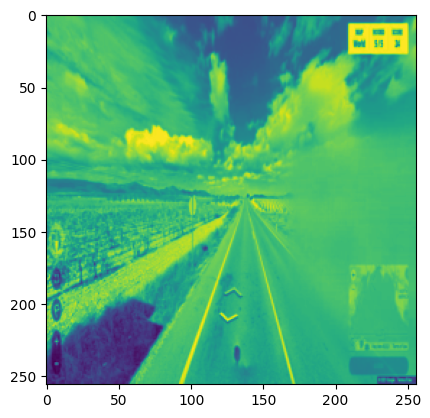

In [ ]:
inputs, classes = next(iter(dataloaders_dict['train']))

plt.imshow(inputs[0][0])

['Australia', 'Poland', 'Russia', 'South_Africa', 'Spain', 'United_States']


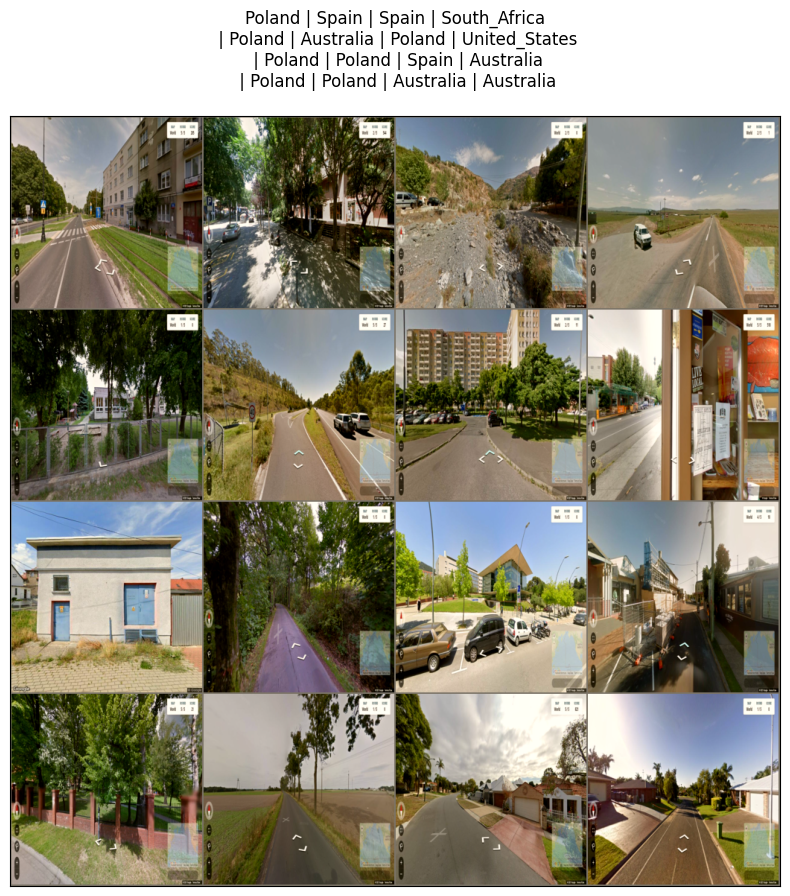

In [ ]:
# Visualize the data within the dataset
import json
#with open('./data_miniplaces_modified/category_names.json', 'r') as f:
 #   class_names = json.load(f)['i2c']
#class_names = {i:name for i, name in enumerate(class_names)}
class_dir = "./Geoguessr-AI1-5/train"
class_names = os.listdir(class_dir)
class_names.sort()
print(class_names)
def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

In [ ]:
inputs

tensor([[[[ 1.1667,  1.1078,  1.1275,  ..., -0.2059, -0.8137, -1.1078],
          [ 1.2059,  1.1863,  1.1275,  ..., -0.1863, -0.8137, -1.0882],
          [ 1.2059,  1.1863,  1.1667,  ..., -0.1667, -0.7941, -1.0686],
          ...,
          [ 0.0490,  0.0294,  0.0098,  ..., -1.4412, -1.8725, -1.9510],
          [ 0.0294, -0.0098,  0.0294,  ..., -1.6569, -1.8333, -1.9706],
          [-0.0098, -0.0294,  0.1078,  ..., -1.6569, -1.6765, -1.7941]],

         [[ 1.1863,  1.1275,  1.1275,  ..., -0.1667, -0.7745, -1.0686],
          [ 1.2255,  1.2059,  1.1275,  ..., -0.1471, -0.7745, -1.0490],
          [ 1.2255,  1.2059,  1.1863,  ..., -0.1275, -0.7549, -1.0294],
          ...,
          [-0.1667, -0.1863, -0.2059,  ..., -1.3431, -1.7549, -1.8137],
          [-0.1863, -0.2255, -0.1863,  ..., -1.5588, -1.7353, -1.8725],
          [-0.2255, -0.2451, -0.1078,  ..., -1.5588, -1.5784, -1.6961]],

         [[ 1.2843,  1.2255,  1.2255,  ..., -0.0098, -0.5392, -0.7745],
          [ 1.3235,  1.3039,  

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("geolocal/StreetCLIP")
pretrained_model = AutoModelForZeroShotImageClassification.from_pretrained("geolocal/StreetCLIP")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pretrained_model.to(device)


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [ ]:
from PIL import Image
image = Image.open('/content/Geoguessr-AI1-5/train/Australia/canvas_1629326044_jpg.rf.d61c57eb7e61bec03989d3a5099c129f.jpg')
#inputs = processor(["Poland", "Australia"], images=inputs['pixel_values'], return_tensors="pt")
#
#outputs = pretrained_model(**inputs)
#logits_per_image = outputs.logits_per_image # this is the image-text similarity score
#probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

#print()

In [ ]:
#logits_per_image

In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers.
# "M" corresponds to maxpooling layer, integers correspond to number of output
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
    """
    Return a nn.Sequential object containing all layers to get the features
    using the CNN. (That is, before the Average pooling layer in the two
    pictures above).

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################
   #print("1")
    if batch_norm:
      #print("3")
      features = nn.Sequential(
            nn.Conv2d(3,64,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.Conv2d(64,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.Conv2d(128,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),

          )



    else:
      #print("4")
      features = nn.Sequential(
            nn.Conv2d(3,64,(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.Conv2d(64,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.Conv2d(128,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),

          )

    #print("2")
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################
        self.classifier = nn.Sequential(
            nn.Linear(3200, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(512, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(256, 6, bias=True),
        )


        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with
# the one given in the instructions above.
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

In [ ]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(), lr=.005 , momentum=0.9)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss.
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             #
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                loss_criterion = get_loss()
                if phase == 'train':
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  #print("1")
                  #print("2")
                  preds = torch.argmax(outputs, dim=1)
                  loss = loss_criterion(outputs,labels)
                  loss.backward()
                  optimizer.step()

                else:
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  #print("3")
                  preds = torch.argmax(outputs, axis=1)
                  #print("4")
                  loss = loss_criterion(outputs,labels)



                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained
                # weights.
                # You should download the trained weights to your local machine.
                # Later, you can load these weights directly without needing to
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)

    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

In [ ]:
# Number of classes in the dataset
num_classes = 6

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders_dict, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

Epoch 0/19
----------


100%|██████████| 405/405 [01:52<00:00,  3.59it/s]


train Loss: 1.7795 Acc: 0.1994


100%|██████████| 116/116 [00:24<00:00,  4.83it/s]


valid Loss: 1.7120 Acc: 0.2570
Epoch 1/19
----------


100%|██████████| 405/405 [01:24<00:00,  4.77it/s]


train Loss: 1.6766 Acc: 0.2923


100%|██████████| 116/116 [00:21<00:00,  5.32it/s]


valid Loss: 1.5858 Acc: 0.3375
Epoch 2/19
----------


100%|██████████| 405/405 [01:25<00:00,  4.73it/s]


train Loss: 1.5622 Acc: 0.3608


100%|██████████| 116/116 [00:23<00:00,  4.98it/s]


valid Loss: 1.4887 Acc: 0.3774
Epoch 3/19
----------


 40%|███▉      | 160/405 [00:35<00:53,  4.56it/s]


KeyboardInterrupt: ignored

In [ ]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()


In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values
    of k.

    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.

    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/925, sum(top5_acc).item()/925))

In [ ]:
test(vgg, dataloaders_dict['test'])

In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders_dict, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 405/405 [01:31<00:00,  4.43it/s]


train Loss: 1.6589 Acc: 0.2872


100%|██████████| 116/116 [00:22<00:00,  5.20it/s]


valid Loss: 1.4367 Acc: 0.4298
Epoch 1/19
----------


100%|██████████| 405/405 [01:28<00:00,  4.60it/s]


train Loss: 1.4156 Acc: 0.4371


100%|██████████| 116/116 [00:22<00:00,  5.06it/s]


valid Loss: 1.3193 Acc: 0.4773
Epoch 2/19
----------


100%|██████████| 405/405 [01:24<00:00,  4.78it/s]


train Loss: 1.2939 Acc: 0.4813


100%|██████████| 116/116 [00:23<00:00,  4.85it/s]


valid Loss: 1.7317 Acc: 0.4314
Epoch 3/19
----------


100%|██████████| 405/405 [01:25<00:00,  4.73it/s]


train Loss: 1.2183 Acc: 0.5090


100%|██████████| 116/116 [00:21<00:00,  5.29it/s]


valid Loss: 1.1739 Acc: 0.5362
Epoch 4/19
----------


100%|██████████| 405/405 [01:27<00:00,  4.61it/s]


train Loss: 1.1693 Acc: 0.5303


100%|██████████| 116/116 [00:23<00:00,  4.92it/s]


valid Loss: 1.1755 Acc: 0.5313
Epoch 5/19
----------


100%|██████████| 405/405 [01:28<00:00,  4.56it/s]


train Loss: 1.1273 Acc: 0.5478


100%|██████████| 116/116 [00:24<00:00,  4.80it/s]


valid Loss: 1.1402 Acc: 0.5605
Epoch 6/19
----------


100%|██████████| 405/405 [01:28<00:00,  4.56it/s]


train Loss: 1.0983 Acc: 0.5582


100%|██████████| 116/116 [00:24<00:00,  4.69it/s]


valid Loss: 1.1304 Acc: 0.5362
Epoch 7/19
----------


100%|██████████| 405/405 [01:29<00:00,  4.52it/s]


train Loss: 1.0465 Acc: 0.5830


100%|██████████| 116/116 [00:24<00:00,  4.79it/s]


valid Loss: 1.0500 Acc: 0.5902
Epoch 8/19
----------


100%|██████████| 405/405 [01:29<00:00,  4.50it/s]


train Loss: 1.0283 Acc: 0.5911


100%|██████████| 116/116 [00:23<00:00,  5.01it/s]


valid Loss: 1.0433 Acc: 0.5929
Epoch 9/19
----------


  0%|          | 0/405 [00:00<?, ?it/s]

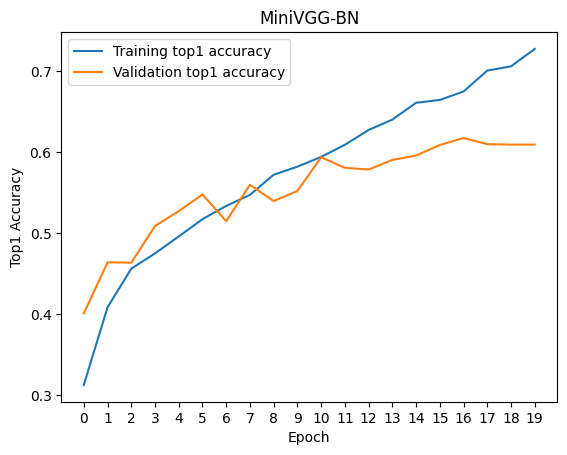

In [ ]:
# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()


In [ ]:
test(vgg_BN, dataloaders_dict['test'])


Top-1 accuracy 5.72%, Top-5 accuracy 9.14%
